# Connect4 Game Detection

This notebook details how to detect the state of a connect4 game from an image. The game is played on a 7x6 grid, with two players, red and yellow. The players take turns dropping a piece into one of the columns, and the first player to get 4 in a row wins. The game can end in a draw if the board is filled without a winner.

## Load in libraries

In [152]:
%pip install opencv-python
%pip install matplotlib
%pip install numpy
%pip install sklearn


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [153]:
# importing required libraries
import cv2
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans

## Load in the image

Pick the image using the file picker below. The image should be a screenshot of the game, with the board fully visible. The board should be centered in the image, and the board should be the only thing in the image.

Dropdown(description='Select Image', index=8, options=('images/connect4_1.jpg', 'images/connect4_10.jpg', 'ima…

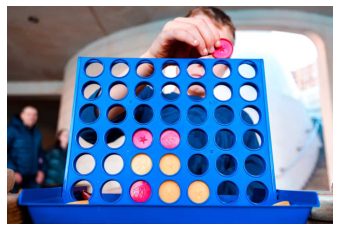

In [154]:
# Create a dropdown menu to select the image
from ipywidgets import interact, widgets
from IPython.display import display, clear_output
import os

# Global values for the image.
img_path = 'images/connect4_1.jpg'
img = cv2.imread(img_path)

# Display the selected image.
def display_image(image):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Update the image variable when the dropdown menu is changed.
def update_image(change):
    global img_path, img

    clear_output()
    display(dropdown)
    img_path = change.new
    img = cv2.imread(img_path)
    display_image(img)

# Get a list of all the images in the images folder. Keep the path in front of the image name.
image_names = ['images/' + image_name for image_name in os.listdir('images/')]

# Create the dropdown menu
dropdown = widgets.Dropdown(options=image_names, description='Select Image')
dropdown.observe(update_image, names='value')
display(dropdown)
display_image(img)


## Preprocess Image

Crop the image to only include the board. This is done so that there is less noise in the image, and the model can focus on the board.

Currently the image is cropped manually, but in the future this could be done automatically, or we could add crosshairs in the camera view to help the user center the board.

In [270]:
class Scaler:
    """
    A class to scale an image down to a smaller size. This is useful for processing large images
    that would take a long time to process at full size. The image is scaled down while maintaining
    its aspect ratio.

    Attributes:
    -----------
    img : numpy.ndarray
        The original image before scaling.
    scaled_img : numpy.ndarray
        The scaled image.
    scale_limit : int
        The maximum size of the image after scaling. If the image is already smaller than this size,
        it will not be scaled.
    scale_percent : float
        The percentage by which the image is scaled down.

    Methods:
    --------
    __init__(self, image, scale_limit=1000)
        Initializes the Scaler object with an image and a scale limit.
    scale_image(self)
        Scales the image down to the specified scale limit.
    get_scaled_image(self)
        Returns the scaled image.
    get_scale_limit(self)
        Returns the scale limit.
    get_scale_percent(self)
        Returns the scale percentage.
    descale_roi(self, roi)
        If the image was scaled down for cropping, this function scales the roi back up to the
        original size of the image.
    """
class Scaler:
    img = None
    scaled_img = None
    scale_limit = 1000
    scale_percent = 1

    def __init__(self, image, scale_limit=1000):
        self.img = image.copy()
        self.scale_limit = scale_limit
        if self.img.shape[0] > self.scale_limit or self.img.shape[1] > self.scale_limit:
            if img.shape[0] > img.shape[1]:
                self.scale_percent = self.scale_limit / img.shape[0]
            else:
                self.scale_percent = self.scale_limit / img.shape[1]
            self.scale_image()

    def scale_image(self):
        width =  int(self.img.shape[1] * self.scale_percent)
        height = int(self.img.shape[0] * self.scale_percent)
        dim = (width, height)
        self.scaled_img = cv2.resize(self.img, dim, interpolation = cv2.INTER_AREA)

    def get_scaled_image(self):
        return self.scaled_img
    
    def get_scale_limit(self):
        return self.scale_limit
    
    def get_scale_percent(self):
        return self.scale_percent
    
    def descale_roi(self, roi):
        # If the image was scaled down for cropping, we should instead scale
        # the roi back up to the original size. This function allows you to
        # pass in a roi that was scaled down and get back a roi that is the
        # same size as the original image.
        if self.img.shape[0] > self.scale_limit or self.img.shape[1] > self.scale_limit:
            roi = [(int(t[0]/self.scale_percent),
                    int(t[1]/self.scale_percent))
                    for t in roi]
        return roi

In [271]:
class Cropper:
    """
    A class to crop an image using mouse events. The user can select a rectangle on the
    image and the image will be cropped to that rectangle. The user can also reset the
    rectangle if they make a mistake. The cropped image can be retrieved using the
    get_cropped_image() method.

    Once the cropped area is selected, the user can press 'c' to crop the image and
    close the window with 'q'. Pressing 'r' will reset the cropping rectangle.

    Attributes:
    -----------
    roi : list
        A list of two tuples representing the top-left and bottom-right corners of the cropping rectangle.
    scaler : Scaler
        The Scaler object used to scale the image down before cropping.
    initial_img : numpy.ndarray
        The original image before scaling and cropping.
    scaled_img : numpy.ndarray
        The original image before cropping.
    crop_img : numpy.ndarray
        The image being displayed with the cropping rectangle drawn on it.
    cropped_img : numpy.ndarray
        The cropped image.

    Methods:
    --------
    __init__(self, image)
        Initializes the Cropper object with an image.
    shape_selection_handler(self, event, x, y, flags, param)
        A callback function for mouse events. This function is called when the user clicks
        or drags on the image.
    crop_image(self)
        Displays the image and waits for the user to select a cropping rectangle. The user
        can press 'r' to reset the rectangle and 'c' to crop the image.
    get_initial_image(self)
        Returns the original image before scaling and cropping.
    get_cropped_image(self)
        Returns the cropped image.
    get_crop_image(self)
        Returns the image being displayed with the cropping rectangle drawn on it.
    get_roi(self)
        Returns the cropping rectangle.
    """
    roi = []
    scaler = None
    initial_img = None
    scaled_img = None
    crop_img = None
    cropped_img = None

    def __init__(self, image):
        self.roi = []
        self.initial_img = image.copy()
        self.scaler = Scaler(self.initial_img)
        self.scaler.scale_image()
        self.scaled_img = self.scaler.get_scaled_image()
        self.crop_img = self.scaled_img.copy()
        self.cropped_img = self.scaled_img.copy()

    def shape_selection_handler(self, event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN:
            self.roi = [(x, y)]
        elif event == cv2.EVENT_LBUTTONUP:
            self.roi.append((x, y))
            cv2.rectangle(self.crop_img, self.roi[0], self.roi[1], (0, 255, 0), 2)
            cv2.imshow("Image", self.crop_img)

    def crop_image(self):
        cv2.namedWindow("Crop Image")
        cv2.setMouseCallback("Crop Image", self.shape_selection_handler)
        while True:
            cv2.imshow("Crop Image", self.crop_img)
            key = cv2.waitKey(1) & 0xFF
            if key == ord("r"):
                self.crop_img = self.scaled_img.copy()
                self.roi = []
            elif key == ord("c"):
                break
        self.roi = self.scaler.descale_roi(self.roi)
        self.cropped_img = crop_image_from_roi(self.initial_img, self.roi)
        cv2.destroyAllWindows()

    def get_initial_image(self):
        return self.scaled_img
    
    def get_cropped_image(self):
        return self.cropped_img
    
    def get_crop_image(self):
        return self.crop_img
    
    def get_roi(self):
        return self.roi


def crop_image_from_roi(image, roi):
    '''
    If there are two reference points, then crop the region of interest
    from the image and display it. Take care of the case where the user
    drags from bottom right to top left instead of top left to bottom right.
    Also take care of the case where the user drags outside the image.
    '''
    if len(roi) == 2:
        x1, y1 = roi[0]
        x2, y2 = roi[1]
        x_min, x_max = min(x1, x2), max(x1, x2)
        y_min, y_max = min(y1, y2), max(y1, y2)
        x_max = min(x_max, image.shape[1])
        y_max = min(y_max, image.shape[0])
        x_min = max(x_min, 0)
        y_min = max(y_min, 0)
        roi = image[y_min:y_max, x_min:x_max]
        return roi

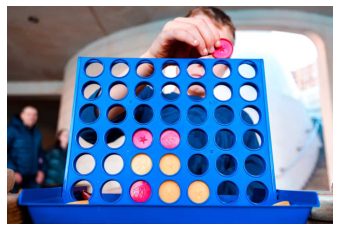

In [272]:
# Scale the image down to a smaller size for easier processing.
scaler = Scaler(img, scale_limit=1000)
scaler.scale_image()
img = scaler.get_scaled_image()
display_image(img)

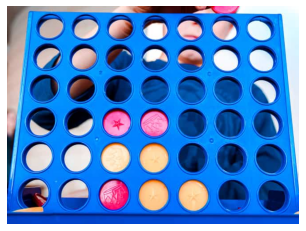

In [273]:
# Create a cropper object and crop the image
cropper = Cropper(img)
cropper.crop_image() # blocking call
img = cropper.get_cropped_image()
display_image(img)

# Close all open windows
cv2.destroyAllWindows()

## Detect the grid circles

### Radius Definition

Determine the radius of the circles to search for based on a cropped image of the board. We just take half the distance of the largest dimention of the cropped image.

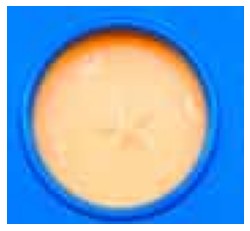

Width of the piece:  87
Height of the piece:  80
Radius of the piece:  43


In [274]:
cropper = Cropper(img)
cropper.crop_image() # blocking call
crop_img = cropper.get_cropped_image()
display_image(crop_img)

width = crop_img.shape[1]
height = crop_img.shape[0]
print("Width of the piece: ", width)
print("Height of the piece: ", height)

radius = max(width, height) / 2
radius = int(radius)
print("Radius of the piece: ", radius)


In [275]:
import numpy as np

def circles_overlap(circle1, circle2):
    x1, y1, r1 = circle1
    x2, y2, r2 = circle2
    distance = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return distance < (r1 + r2)

def remove_overlapping_circles(circles):
    non_overlapping_circles = []
    for circle in circles:
        overlap = False
        for other_circle in non_overlapping_circles:
            if circles_overlap(circle, other_circle):
                overlap = True
                if circle[2] < other_circle[2]:  # If current circle is smaller, replace the other_circle
                    non_overlapping_circles.remove(other_circle)
                    non_overlapping_circles.append(tuple(circle))
                break
        if not overlap:
            non_overlapping_circles.append(tuple(circle))
    return non_overlapping_circles


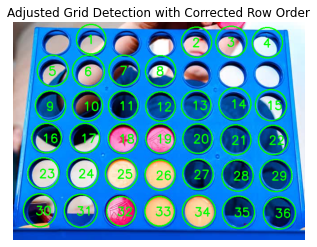

In [276]:
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Set minimum and maximum radius of the circles to detect
radius_delta = 10
min_radius = radius - radius_delta
max_radius = radius + radius_delta
average_radius = (min_radius + max_radius) / 2
average_radius = int(average_radius)

# Use Hough Transform to detect circles
circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, dp=1, minDist=average_radius, param1=200, param2=20,
                           minRadius=min_radius, maxRadius=max_radius)
if circles is None:
    raise ValueError('No circles found!')
# if len(circles[0]) != 42:
#     raise ValueError('Incorrect number of circles found!')

# Convert circles to list of tuples and remove overlapping circles
circles_list = [tuple(circle) for circle in circles[0]]
non_overlapping_circles = remove_overlapping_circles(circles_list)
circles = np.array([non_overlapping_circles])


# Cluster the y-coordinates to determine distinct rows
kmeans = KMeans(n_clusters=6)  # Assuming 6 rows in Connect 4
y_coords = circles[0][:, 1].reshape(-1, 1)
kmeans.fit(y_coords)

# Get and sort the cluster centers
sorted_centers = sorted([(center[0], idx) for idx, center in enumerate(kmeans.cluster_centers_)])

# Create a mapping from original cluster label to sorted order
label_map = {original_idx: sorted_idx for sorted_idx, (_, original_idx) in enumerate(sorted_centers)}

# Use the label_map to get labels in sorted order
labels = [label_map[label] for label in kmeans.labels_]

# Sort by the new labels (rows) and then by x-coordinate within each row
sorted_circles = [circle for _, circle in sorted(zip(labels, circles[0]), key=lambda c: (c[0], c[1][0]))]

# Create a new image for visualization
vis_img = img_rgb.copy()

# Draw the sorted circles on the image and annotate with their grid position
for idx, (x, y, r) in enumerate(sorted_circles):
    x, y, r = int(x), int(y), int(r)
    cv2.circle(vis_img, (x, y), r, (0, 255, 0), 2)  # draw the circle in green
    text = str(idx + 1)
    cv2.putText(vis_img, text, (x - 10, y + 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

# Display the image with sorted circles
plt.imshow(vis_img)
plt.title('Adjusted Grid Detection with Corrected Row Order')
plt.axis('off')
plt.show()


## Detect the pieces

### Define Pixel Colors

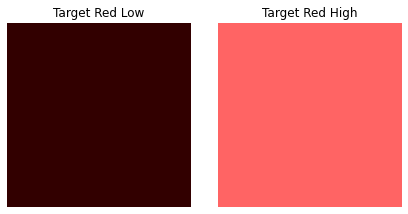

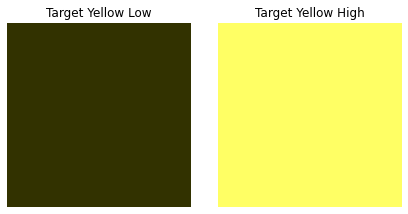

In [277]:
# Define color boundaries
red_low = np.array([50, 0, 0])
red_high = np.array([255, 100, 100])
yellow_low = np.array([50, 50, 0])
yellow_high = np.array([255, 255, 100])

def display_colors(color_low, color_high, color_name):
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(np.full((50, 50, 3), color_low), vmin=0, vmax=255)
    plt.title(f'Target {color_name} Low')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(np.full((50, 50, 3), color_high), vmin=0, vmax=255)
    plt.title(f'Target {color_name} High')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

display_colors(red_low, red_high, 'Red')
display_colors(yellow_low, yellow_high, 'Yellow')

### Detect Piece Positions

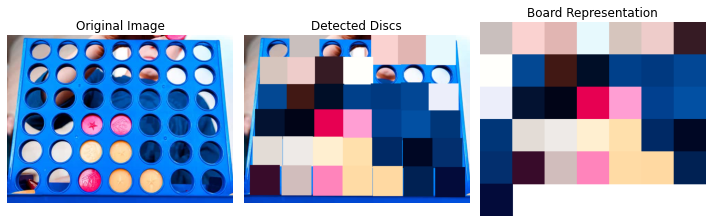

ValueError: cannot reshape array of size 36 into shape (6,7)

In [278]:
board = []

# Create a blank white image for board representation
board_img = np.ones((300, 350, 3), dtype=np.uint8) * 255  # Assuming 50x50 pixels per cell

for idx, (x, y, r) in enumerate(sorted_circles):
    x, y, r = int(x), int(y), int(r)
    pixel = img_rgb[y, x]
    int_pixel = tuple(map(int, pixel))
    
    # Draw the sampled pixel using the integer values
    cv2.rectangle(vis_img, (x-average_radius, y-average_radius), (x+average_radius, y+average_radius), int_pixel, -1)
    
    # Determine the disc color and fill the corresponding position in board_img with the actual pixel color
    row = idx // 7
    col = idx % 7
    if np.all((red_low <= pixel) & (pixel <= red_high)):
        board.append('R')
        cv2.rectangle(board_img, (col*50, row*50), ((col+1)*50, (row+1)*50), int_pixel, -1)
    elif np.all((yellow_low <= pixel) & (pixel <= yellow_high)):
        board.append('Y')
        cv2.rectangle(board_img, (col*50, row*50), ((col+1)*50, (row+1)*50), int_pixel, -1)
    else:
        board.append('O')
        cv2.rectangle(board_img, (col*50, row*50), ((col+1)*50, (row+1)*50), int_pixel, -1)

# Display the visualization image with detected discs
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(img_rgb)
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(vis_img)
plt.title('Detected Discs')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(board_img)
plt.title('Board Representation')
plt.axis('off')
plt.tight_layout()
plt.show()

# Assuming a 6x7 board for Connect 4
board_matrix = np.array(board).reshape(6, 7)
print(board_matrix)


## Determine the winner

In [ ]:
def check_winner(board):
    patterns = ['RRRR', 'YYYY']
    
    # Check rows
    for row in board:
        for pattern in patterns:
            if pattern in ''.join(row):
                return pattern[0]
                
    # Check columns
    for col in board.T:
        for pattern in patterns:
            if pattern in ''.join(col):
                return pattern[0]

    # Check diagonals
    diagonals = [board.diagonal(i) for i in range(-3, 4)]
    antidiagonals = [np.fliplr(board).diagonal(i) for i in range(-3, 4)]
    for diagonal in diagonals + antidiagonals:
        for pattern in patterns:
            if pattern in ''.join(diagonal):
                return pattern[0]
    return None

winner = check_winner(board_matrix)
if winner == 'R':
    print("Red wins!")
elif winner == 'Y':
    print("Yellow wins!")
else:
    print("No winner yet!")


Yellow wins!
